## 路网构建与预处理

In [2]:
import osmnx as ox
from networkx import DiGraph, is_isolate
import numpy as np

def build_road_network(place_name="海淀区, 北京", simplify=True):
    """构建带权有向路网"""
    # 从OSM下载原始路网
    G = ox.graph_from_place(place_name, network_type='drive', simplify=simplify)
    
    # 转换为带权有向图
    weighted_G = DiGraph()
    weighted_G.graph["crs"] = G.graph["crs"]  # 复制原始图的 CRS 属性
    
    for node, data in G.nodes(data=True):
        # 复制节点的属性，包括 x 和 y 坐标
        weighted_G.add_node(node, **data)

    for u, v, data in G.edges(data=True):
        # 计算路段长度作为权重
        length = data.get('length', 100)  # 默认长度100米
        weighted_G.add_edge(u, v, weight=length)
        
        # 处理单行道
        if data.get('oneway', False):
            weighted_G.add_edge(v, u, weight=length)
    
    # 检查并移除孤立节点
    isolated_nodes = [node for node in weighted_G.nodes if is_isolate(weighted_G, node)]
    if isolated_nodes:
        print(f"发现孤立节点：{isolated_nodes}")
        weighted_G.remove_nodes_from(isolated_nodes)
    else:
        print("未发现孤立节点")
    
    return weighted_G

# 示例使用
haidian_road_net = build_road_network()
print(f"路网节点数：{len(haidian_road_net.nodes)}，边数：{len(haidian_road_net.edges)}")

# 打印部分节点的坐标信息
print("部分节点的坐标信息：")
for i, (node, data) in enumerate(haidian_road_net.nodes(data=True)):
    print(f"节点 {node}: 坐标 = {data['x']}, {data['y']}")
    if i >= 9:  # 只打印前 10 个节点
        break

未发现孤立节点
路网节点数：13180，边数：37771
部分节点的坐标信息：
节点 27484724: 坐标 = 116.3192235, 39.9097235
节点 27484729: 坐标 = 116.3471527, 39.9638588
节点 27484730: 坐标 = 116.3473067, 39.9671179
节点 27484733: 坐标 = 116.3467493, 39.9665093
节点 27484736: 坐标 = 116.3637488, 39.9667321
节点 27484993: 坐标 = 116.3152706, 39.9062394
节点 27484994: 坐标 = 116.3150345, 39.9062397
节点 27484999: 坐标 = 116.3106697, 39.9062709
节点 27485058: 坐标 = 116.3227236, 39.9096733
节点 27486094: 坐标 = 116.3639092, 39.9662639


## 坐标到路网的映射

In [8]:
def locate_nodes(network, origins, destinations):
    """将经纬度坐标映射到最近路网节点"""
    nodes = []
    for point in origins + destinations:
        node = ox.distance.nearest_nodes(network, point[0], point[1])
        nodes.append(node)
    return nodes[:len(origins)], nodes[len(origins):]

# 示例坐标（假设的起点终点）
start_point = (116.357063,39.964955)  # 北京邮电大学北门
end_point = (116.315681,39.990138)   # 北京大学东南门

start_nodes, end_nodes = locate_nodes(haidian_road_net, [start_point], [end_point])
print(f"起点映射节点：{start_nodes[0]}，终点映射节点：{end_nodes[0]}")

# 获取节点的坐标
start_node_data = haidian_road_net.nodes[start_nodes[0]]
end_node_data = haidian_road_net.nodes[end_nodes[0]]

print(f"起点坐标：{start_node_data['x']}, {start_node_data['y']}")
print(f"终点坐标：{end_node_data['x']}, {end_node_data['y']}")

起点映射节点：8073702514，终点映射节点：9156861087
起点坐标：116.3583474, 39.965047
终点坐标：116.3157172, 39.9909336


In [3]:
import folium
import osmnx as ox

# 创建 Folium 地图
def visualize_nodes_on_map(network, map_center=(39.990138, 116.315681), zoom_start=13):
    """在地图上显示所有节点，并高亮特定节点"""
    # 创建地图对象
    m = folium.Map(location=map_center, zoom_start=zoom_start)

    # 遍历所有节点并添加到地图
    for node, data in network.nodes(data=True):
        if node in [9369533019, 10068907123, 1190930364, 1721642053, 754515780, 1584011213, 529504071,
                    244467919, 1597402911, 1732782032, 529544520]:  # 高亮特定节点
            folium.CircleMarker(
                location=(data['y'], data['x']),  # 节点的纬度和经度
                radius=6,  # 高亮节点的大小
                color='red',  # 高亮节点的颜色
                fill=True,
                fill_opacity=1.0,
                popup=f"节点 {node}"  # 显示节点 ID
            ).add_to(m)
        else:  # 普通节点
            folium.CircleMarker(
                location=(data['y'], data['x']),  # 节点的纬度和经度
                radius=2,  # 普通节点的大小
                color='blue',  # 普通节点的颜色
                fill=True,
                fill_opacity=0.7
            ).add_to(m)

    return m

# 构建路网
haidian_road_net = build_road_network()

# 可视化所有节点
map_center = (39.990138, 116.315681)  # 北京大学东南门的坐标
m = visualize_nodes_on_map(haidian_road_net, map_center=map_center)

# 保存地图到 HTML 文件
m.save("haidian_road_network_nodes.html")
print("地图已保存为 haidian_road_network_nodes.html")

未发现孤立节点
地图已保存为 haidian_road_network_nodes.html


In [2]:
import folium
import osmnx as ox

# 创建 Folium 地图
def visualize_nodes_on_map(network, map_center=(39.990138, 116.315681), zoom_start=13):
    """在地图上显示所有节点，并高亮特定节点"""
    # 创建地图对象
    m = folium.Map(location=map_center, zoom_start=zoom_start)

    # 遍历所有节点并添加到地图
    for node, data in network.nodes(data=True):
        if node in [27547653, 1767304562, 9814884787, 9810784275, 1350996022, 1350996030, 1226548265, 9814884785, 1350996065, 1584068007, 1819948385, 1350996079, 1350996086, 292592498, 292592153, 292592090, 1816066968, 1350327458, 244467922, 1364156215, 288190895, 1361192322, 1293134755, 321557747, 380731617, 604939234, 604939235, 604939236, 1765070599, 1765070605, 1420909526, 239453042, 1597419021, 286387098, 286387102, 371158000]:  # 高亮特定节点
            folium.CircleMarker(
                location=(data['y'], data['x']),  # 节点的纬度和经度
                radius=6,  # 高亮节点的大小
                color='red',  # 高亮节点的颜色
                fill=True,
                fill_opacity=1.0,
                popup=f"节点 {node}"  # 显示节点 ID
            ).add_to(m)
        else:  # 普通节点
            folium.CircleMarker(
                location=(data['y'], data['x']),  # 节点的纬度和经度
                radius=2,  # 普通节点的大小
                color='blue',  # 普通节点的颜色
                fill=True,
                fill_opacity=0.7
            ).add_to(m)

    return m

# 构建路网
haidian_road_net = ox.graph_from_place("海淀区, 北京", network_type='drive', simplify=True)

# 可视化所有节点
map_center = (39.990138, 116.315681)  # 北京大学东南门的坐标
m = visualize_nodes_on_map(haidian_road_net, map_center=map_center)

# 保存地图到 HTML 文件
m.save("haidian_road_network_nodes.html")
print("地图已保存为 haidian_road_network_nodes.html")

地图已保存为 haidian_road_network_nodes.html


## 路径生成算法改造

In [18]:
from dfwa_tsp import DFWAlgorithm

class PathFirework(DFWAlgorithm):
    def __init__(self, network, start, end, **kwargs):
        # 构建邻接矩阵
        self.network = network
        self.node_list = list(network.nodes)
        self.dimension = len(self.node_list)
        
        # 创建距离矩阵
        self.distance_matrix = np.zeros((self.dimension, self.dimension))
        for i, u in enumerate(self.node_list):
            for j, v in enumerate(self.node_list):
                if network.has_edge(u, v):
                    self.distance_matrix[i][j] = network[u][v]['weight']
                else:
                    self.distance_matrix[i][j] = np.inf
        
        # 初始化参数
        super().__init__(tag="虚拟路径问题", **kwargs)
        
        # 设置起点终点约束
        self.start_idx = self.node_list.index(start)
        self.end_idx = self.node_list.index(end)
    
    def initialize_fireworks(self):
        """生成初始路径种群"""
        self.fireworks = []
        for _ in range(self.size):
            # 使用A*算法生成初始路径
            path = ox.shortest_path(self.network, 
                                  self.node_list[self.start_idx],
                                  self.node_list[self.end_idx],
                                  weight='weight')
            if path:
                self.fireworks.append([self.node_list.index(n) for n in path])
    
    def calculate_distance(self, path):
        """计算路径总长度"""
        total = 0
        for i in range(len(path)-1):
            u = self.node_list[path[i]]
            v = self.node_list[path[i+1]]
            total += self.network[u][v]['weight']
        return total

In [11]:
import random

def path_mutation(path, network, max_retry=5):
    """路径变异操作"""
    for _ in range(max_retry):
        # 随机选择两个切割点
        if len(path) < 3:
            return path
        
        i, j = sorted(np.random.choice(len(path)-1, 2, replace=False))
        seg_start = path[i]
        seg_end = path[j+1]
        
        # 尝试寻找替代路径
        try:
            new_seg = ox.shortest_path(network, 
                                     network.nodes[seg_start],
                                     network.nodes[seg_end],
                                     weight='weight')
            if new_seg and len(new_seg) < (j - i + 1)*1.5:  # 限制绕路程度
                return path[:i] + [network.nodes.index(n) for n in new_seg] + path[j+1:]
        except:
            continue
    return path

def path_crossover(path1, path2):
    """路径交叉操作"""
    if len(path1) < 2 or len(path2) < 2:
        return path1, path2
    
    # 寻找共同节点
    common_nodes = set(path1[1:-1]).intersection(path2[1:-1])
    if not common_nodes:
        return path1, path2
    
    # 随机选择交叉点
    cross_point = random.choice(list(common_nodes))
    idx1 = path1.index(cross_point)
    idx2 = path2.index(cross_point)
    
    return path1[:idx1] + path2[idx2:], path2[:idx2] + path1[idx1:]

## 完整路径生成流程

In [13]:
def valid_path(path, network):
    """检查路径连续性"""
    for i in range(len(path)-1):
        if not network.has_edge(path[i], path[i+1]):
            return False
    return True

def generate_paths(network, start_point, end_point, 
                  top_k=10, max_length_ratio=1.5,
                  population_size=20, generations=100):
    # 初始化算法
    algo = PathFirework(network=network,
                      start=ox.distance.nearest_nodes(network, *start_point),
                      end=ox.distance.nearest_nodes(network, *end_point),
                      size=population_size,
                      epoch=generations,
                      amp=50)
    
    # 运行优化
    _, _, best_length, best_path = algo.solve()
    
    # 获取所有非支配解
    all_paths = []
    for path in algo.fireworks + algo.sparks:
        if valid_path(path, network):
            all_paths.append(path)
    
    # 过滤绕路路径
    filtered = []
    shortest = best_length
    for p in all_paths:
        length = algo.calculate_distance(p)
        if length <= shortest * max_length_ratio:
            filtered.append((length, p))
    
    # 按长度排序
    filtered.sort(key=lambda x: x[0])
    
    # 转换为实际节点序列
    final_paths = []
    for length, path in filtered[:top_k]:
        node_path = [network.nodes[v]['x'] for v in path]
        final_paths.append({
            "length": length,
            "coordinates": [(network.nodes[node]['x'], network.nodes[node]['y']) 
                           for node in path]
        })
    
    return final_paths

In [19]:
from matplotlib import pyplot as plt

def visualize_paths(network, paths, start_point, end_point):
    # 创建地图底图
    fig, ax = ox.plot_graph(network, show=False, close=False,
                           edge_color='gray', node_size=0)
    
    # 绘制所有路径
    colors = plt.cm.jet(np.linspace(0,1,len(paths)))
    for i, path in enumerate(paths):
        lats = [p[1] for p in path['coordinates']]
        lons = [p[0] for p in path['coordinates']]
        ax.plot(lons, lats, color=colors[i], linewidth=2, 
               label=f'Path {i+1} ({path["length"]/1000:.1f}km)')
    
    # 标记起终点
    ax.scatter(start_point[0], start_point[1], c='green', s=200, 
              edgecolors='black', label='Start')
    ax.scatter(end_point[0], end_point[1], c='red', s=200, 
              edgecolors='black', label='End')
    
    plt.legend()
    plt.title(f"Found {len(paths)} Reasonable Paths")
    plt.show()

# 执行流程
if __name__ == "__main__":
    # 构建路网
    road_net = build_road_network()
    
    # 定义起终点
    start = (116.3060, 39.9875)  # 中关村
    end = (116.3335, 39.9995)    # 北大东门
    
    # 生成路径
    paths = generate_paths(road_net, start, end, 
                          top_k=5, max_length_ratio=1.3)
    
    # 可视化
    visualize_paths(road_net, paths, start, end)

未发现孤立节点


TypeError: DFWAlgorithm.__init__() missing 1 required positional argument: 'filename'

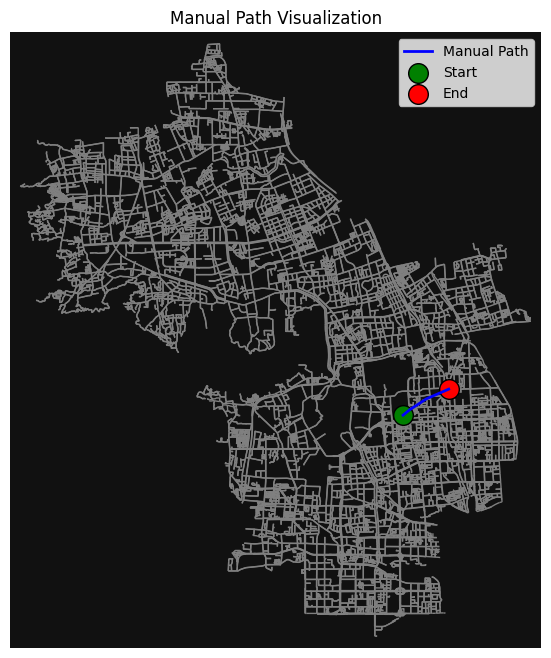

In [20]:
import osmnx as ox
import matplotlib.pyplot as plt

# 构建路网
def build_road_network(place_name="海淀区, 北京", simplify=True):
    """构建带权有向路网"""
    return ox.graph_from_place(place_name, network_type='drive', simplify=simplify)

# 手动绘制路径
def visualize_manual_path(network, path_coordinates, start_point, end_point):
    # 创建地图底图
    fig, ax = ox.plot_graph(network, show=False, close=False,
                            edge_color='gray', node_size=0)
    
    # 绘制路径
    lats = [coord[1] for coord in path_coordinates]
    lons = [coord[0] for coord in path_coordinates]
    ax.plot(lons, lats, color='blue', linewidth=2, label='Manual Path')
    
    # 标记起点和终点
    ax.scatter(start_point[0], start_point[1], c='green', s=200, 
               edgecolors='black', label='Start')
    ax.scatter(end_point[0], end_point[1], c='red', s=200, 
               edgecolors='black', label='End')
    
    plt.legend()
    plt.title("Manual Path Visualization")
    plt.show()

# 执行流程
if __name__ == "__main__":
    # 构建路网
    road_net = build_road_network()
    
    # 定义起终点
    start = (116.3060, 39.9875)  # 中关村
    end = (116.3335, 39.9995)    # 北大东门
    
    # 手动定义路径的坐标
    manual_path = [
        (116.3060, 39.9875),  # 起点
        (116.3100, 39.9900),  # 中间点
        (116.3200, 39.9950),  # 中间点
        (116.3335, 39.9995)   # 终点
    ]
    
    # 可视化手动路径
    visualize_manual_path(road_net, manual_path, start, end)